# Iterative Prisoners Dilemma (IPD)

# Group members and contributions

*   **Mattia Figaro**: Implementation of strategies, point 1 (1v1 battle) and comments, point 2 (tournament) and comments, point 3 (deathmatch) and comments, collaboration to adjustments of point 4 (mutations).
*   **Francesco Rossato**: Introduction, Implementation of strategies, point 1 (1v1 battle) and comments, point 2 (tournament) and comments, point 3 (deathmatch) and comments, alternative implementation of point 4.
*   **Lisa Arnone**: Collaboration on proportional evolution (deathmatch), implementation of mutated strategies and functions, point 4 (mutations) and comments.



## Parameters choice
The Prisoner's Dilemma (PD) is a classical game analyzed in game theory, which is widely used to model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance. The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is obvious that for both players the winning strategy is to NOT cooperate. Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude is expected to emerge. The goal of this project is to test this hypothesis.

The main metrics that define the game evolution is the choice of rewards for the different behaviours of players. Those rewards are specified with the so called **payoff matrix** $M$, a $2\times2$ matrix as follows
$$M=\begin{bmatrix}
R & S\\
T & P
\end{bmatrix}$$
where:
* if both players cooperate, they both get $R$ points
* if both players defeat, they both get $P$ points
* if one player cooperates and the other one defeats, the cooperating one will get $S$ points, while the defeating one will get $T$ points.

We set those parameters as $R=3$, $S=0$, $T=5$, $P=2$.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm

We chose to implement the different strategies with a stateless approach in mind, since the only needed information is the opponent's previous move in the case of the **tit-for-tat** strategy. The implementation of the strategies consists of a series of functions, not classes, which would consists in a stateful approach.
Another caveat is that in this way the logic of the **prickly** strategy must be managed by the main function with a flag that is triggered as soon as the opponent makes the decision to defect, but in any case this approach is less cumbersome than a set of classes.

We have defined the suggested strategies plus some additional possibilities as follows:

*   **nice guy**: always cooperates independently from the opponent's behaviour
*   **bad guy**: always defect independently from the opponent's behaviour
*   **mainly nice**: defects with a given probability, where such probability must be smaller than 0.5
*   **mainly bad**: defects with 1 - a given probability, where such probability must be smaller than 0.5
*   **tit for tat**: replays the opponent's last move
*   **drunk**: chooses whether to cooperate or to defect by tossing a fair coin
*   **prickly**: starts by cooperating, but if the opponent defects, it will continue to defect forever, never forgiving.



In [ ]:
### constants ###
uc = np.array([1,0]).T # vertical vector to return in case of cooperation
ud = np.array([0,1]).T # vertical vector to return in case of defect

# payoff matrix
R = 4
S = 0
T = 5
P = 1

R = 3
S = 0
T = 5
P = 2
M = np.array([[R, S], [T, P]])

### strategies definitions ###

# nice guy
# @param: prob just so that every function has the same parameters
# @param: move just so that every function has the same parameters
# @param: evilOpponent just so that every function has the same parameters
def nice_guy(prob, move, evilOpponent=False):
  return uc

# bad guy
# @param: prob just so that every function has the same parameters
# @param: move just so that every function has the same parameters
# @param: evilOpponent just so that every function has the same parameters
def bad_guy(prob, move, evilOpponent=False):
  return ud

# mainly nice
# @param: prob is the probability of defection (must be less than 0,5)
# @param: move just so that every function has the same parameters
# @param: evilOpponent just so that every function has the same parameters
def mainly_nice(prob, move, evilOpponent=False):
  if prob >= 0.5:
    raise AttributeError('Error: in a mainly nice approch you need to enter a value of prob < 0.5')
  if np.random.rand() <= prob:
    return ud
  return uc

# mainly bad
# @param: prob is the probability of cooperation (must be less than 0,5)
# @param: move just so that every function has the same parameters
# @param: evilOpponent just so that every function has the same parameters
def mainly_bad(prob, move, evilOpponent=False):
  prob = 1 - prob
  if prob <= 0.5:
    raise AttributeError('Error: in a mainly bad approch you need to enter a value of prob > 0.5')
  if np.random.rand() <= prob:
    return ud
  return uc

# tit-for-tat
# @param: prob just so that every function has the same parameters
# @param: move is opponent's last move
# @param: evilOpponent just so that every function has the same parameters
def tit_for_tat(prob, move, evilOpponent=False):
  return move

# drunk
# @param: prob just so that every function has the same parameters
# @param: move just so that every function has the same parameters
# @param: evilOpponent just so that every function has the same parameters
def drunk(prob=0, move=uc, evilOpponent=False):
  if np.random.randint(0,2):
    return uc
  return ud

# prickly
# @param: prob just so that every function has the same parameters
# @param: move just so that every function has the same parameters
# @param: evilOpponent set to true if the opponent has made a bad move
# since we opted for a stateless approach, the evilOpponent flag must be managed by the calling function
def prickly(prob=0, move=uc, evilOpponent=False):
  if evilOpponent: return ud
  return uc


# Point 1: battle 1v1

In this section, we evaluate the cumulative rewards obtained by the different strategies in some selected cases.

The cases such as
* good guy vs good guy
* bad guy vs bad guy
* good guy vs tit for tat
* bad guy vs tit for tat
* prickly vs good guy
* prickly vs tit for tat

and some others are considered trivial and not evaluated. In any case, some extra comparisons will be available anyway in the next point where each strategy will face all the others.

The function defined below is useful to create a match between two differents strategies. It accepts the two type of strategies, that must be within the ones defined in the above section, the two probability values, that are basically related only to strategies like *mainly bad* or *mainly nice*, the moves of previous round and the number of matches to perform. It returns two lists that collect all the cumulative scores obtained by each strategy after every match.

In [ ]:
### 1) One Vs One ###

# one Vs one
# @param: f1 is the first strategy
#         f2 is the second strategy
#         n is the number of matches
def one_vs_one(player1, prob1, move1, player2, prob2, move2, n):
  res1 = [] # points awarded to the player 1
  res2 = [] # points awarded to the player 2
  evilOpponent = False # flag to signal to the prickly strategy whether the opponent defected once
  for i in range(n):
    u1 = player1(prob1, move1, evilOpponent)
    u2 = player2(prob2, move2, evilOpponent)

    # check whether the opponent of the pickly strategy made the first bad move
    if np.array_equal(u1, ud) or np.array_equal(u2, ud):
      evilOpponent=True

    # storing each player's opponent last move
    move1 = u2
    move2 = u1

    # curr rewards
    r1 = np.dot(u1, np.dot(M, u2))
    r2 = np.dot(u2, np.dot(M, u1))

    res1.append(r1)
    res2.append(r2)

  # cumulative rewards
  res1 = np.cumsum(res1)
  res2 = np.cumsum(res2)

  return (res1, res2)


### Results plot

The below function is useful to make a subplots off all the desired matches between the strategies. It basically only needs two lists in which each element is a tupla with the string and function name of each strategy, and aslo the number of matches to perform.


In [ ]:
# one vs one plots
# @param: two lists  of tuples with the axis functions and names
# @output: plots the one vs one matches
def one_vs_one_plots(axis_name, axis_func, matches = 50):

  # fix number of columns
  num_cols = 3

  # number of rows
  n = len(axis_name)
  num_rows = round(n / 3)

  # create the figure
  fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,15))

  # indeces of subplots
  x, y = 0, -1

  # plot all the axis
  for i in range(n):
    # update the indeces of subplots
    y += 1
    if(y == num_cols):
      y = 0
      x += 1

    # make the simulation
    res1, res2 = one_vs_one(axis_func[i][0], 0.2, uc, axis_func[i][1], 0.2, uc, matches)

    # set the labels
    ax[x,y].plot(res1, label=axis_name[i][0])
    ax[x,y].plot(res2, label=axis_name[i][1])
    ax[x,y].set_title(axis_name[i][0] + ' VS ' + axis_name[i][1])
    ax[x,y].set_xlabel('matches')
    ax[x,y].set_ylabel('cumulative reward')
    ax[x,y].legend()

  plt.tight_layout()
  plt.show()



### Our cases of study
As we have already told, only some more interesting cases will be considered. They are the following:
* **nice guy** vs **mainly nice**
* **tit-for-tat** vs **mainly nice**
* **drunk** vs **tit-for-tat**
* **nice guy** vs **mainly nice**
* **tit-for-tat** vs **mainly bad**
* **drunk** vs **mainly nice**
* **prickly** vs **mainly nice**
* **prickly** vs **mainly bad**
* **prickly** vs bad guy

Each of the following plots corresponds to the evolution of the cumulative scores of the addressed strategy couples over a number of matches equals to 50. Of course, all the parameters can be changed in order to obtain other different desidered configurations.

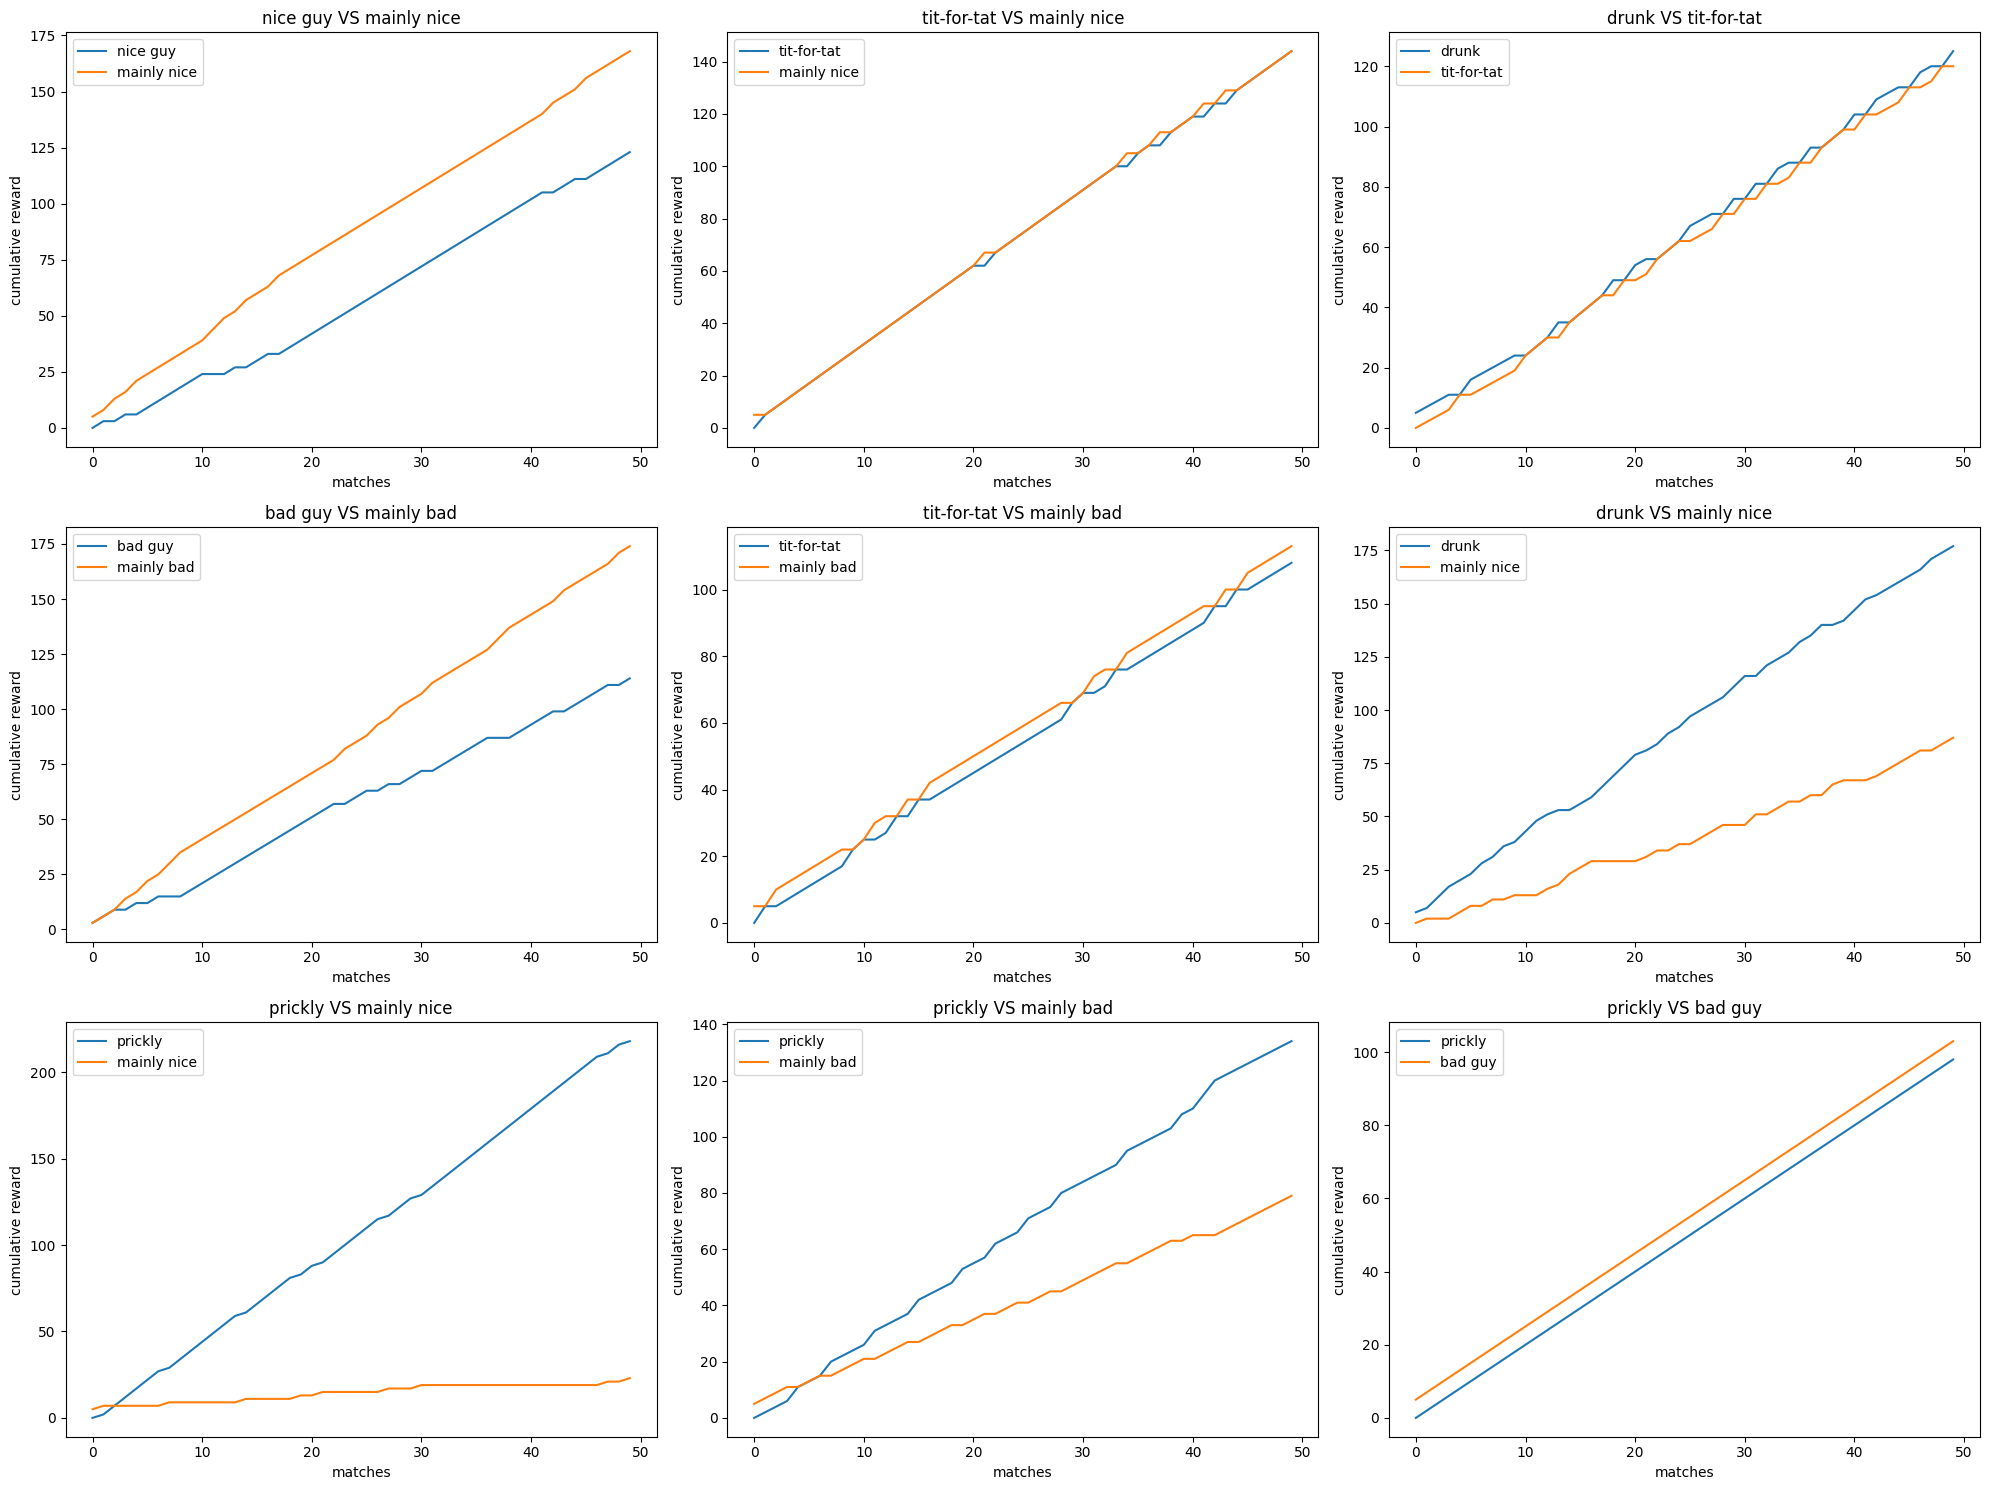

In [ ]:
axis_name = [('nice guy', 'mainly nice'), ('tit-for-tat', 'mainly nice'), ('drunk', 'tit-for-tat'), ('bad guy', 'mainly bad'), ('tit-for-tat', 'mainly bad'), ('drunk', 'mainly nice'), ('prickly', 'mainly nice'), ('prickly', 'mainly bad'), ('prickly', 'bad guy')]
axis_func = [(nice_guy, mainly_nice), (tit_for_tat, mainly_nice), (drunk, tit_for_tat), (nice_guy, mainly_nice), (tit_for_tat, mainly_bad), (drunk, mainly_nice), (prickly, mainly_nice), (prickly, mainly_bad), (prickly, bad_guy)]

one_vs_one_plots(axis_name, axis_func, matches=50)

## Results analysis

It's interesting to note that basically we can distinguish two main types of behaviour and one extra particular case.

* **Clear winner:** this is the case of nice guy vs mainly nice, bad guy vs mainly bad, drunk vs mainly nice, prickly vs mainly nice and prickly vs mainly bad. The main characteristic that distinguishes the winners is that they are somehow meaner than the losers. This is beacuse they have a higher intrinsic probabilities to have a bad behaviour. Strategically, in 1vs1 battle, a bad behaviour will result in a win or a tie. The most clear example is the prickly vs mainly nice, in which the second has a good behaviour almost everytime but at the first time that he defects, it unleashes the wrath of the opponent that will defect forever. It is also interesting the case of drunk vs mainly nice in which the key is the fact the the drunk strategy has basically a bad behaviour probability of 0.5, instead of the other one that usually has a probability of 0.2. As we will highlight more later, the meaner you are and more likely is your win. Of course, increasing the number of matches for each challege we will also emphasise the difference between the two scores.

* **Constant balance:** this is the case of configurations like tit-for-tat vs mainly nice or more in general to the strategies that have a similar probability to be bad. Usually this happens when one of the two players is the tit-for-tat, since it basically copies the last move of the opponent, and so it cannot be at a disadvantage of more than one defeat, since in the following turn it will compensate the loss or will keep it constant.

* **Parallelism:** this is the case of prickly vs bad guy, in which the two strategies exhibit an identical behaviour basically from the start. At that moment, the bad guy basically triggers the wrath of the prickly that becomes itself a bad guy, and so they mantain the same initial gap, appearing as two parallel lines.

# Point 2: Tournament

In this point, each strategy will face all the other ones, including themself, in a battle of 5000 games. At the end what we obtained is a table in which we can see the scores the each strategies has obtained against each other one. Please notice that the computational results may differ from a computation to another since most of the strategies are not deterministic but instead stochastic.

In [ ]:
### 2) Tournament ###

strategies = [nice_guy, bad_guy, mainly_nice, mainly_bad, tit_for_tat, drunk, prickly]
strat_name = ['nice guy', 'bad guy', 'mainly nice', 'mainly bad', 'tit-for-tat', 'drunk', 'prickly']
df = pd.DataFrame(columns=strat_name, index=strat_name)

# tournament simualtion
for j, col in enumerate(strategies):
  for i, row in enumerate(strategies):
    res1, res2 = one_vs_one(row, 0.3, uc, col, 0.2, uc, 5000)
    df.iloc[i, j] = res1[-1]

# who is better in general?
mean = df.mean(axis=1)
df['mean'] = round(mean,2)
df = df.sort_values(by='mean')
display(df)

,nice guy,bad guy,mainly nice,mainly bad,tit-for-tat,drunk,prickly,mean
nice guy,15000,0,11904,3084,15000,7506,15000,9642.00
mainly nice,17980,2974,14769,6124,13523,10532,2981,9840.43
drunk,20044,4942,17028,7798,12434,12543,4999,11398.29
mainly bad,21938,6870,19002,10048,11450,14429,7027,12966.29
tit-for-tat,15000,9998,14002,10989,15000,12506,15000,13213.57
bad guy,25000,10000,22024,13006,10003,17350,10003,15340.86
prickly,15000,9998,22088,13103,15000,17450,15000,15377.00


## Considerations on the results
It does not have so much sense to focus on each sigle possible combination, but we can analyse some interesting cases. Of course, the already discovered behavior that the ones that are usually meaner have more probability to win is still present. For that reason one of the best strategy is the bad guy, but it is not the greatest, as we can wrongly think at first impact, since there is another one that on average performes better. Another easy mistake is to think that the nice guy is the worst, since the mainly nice occupies this position. This is beacuse when they match a bad behaviour opponent of course the mainly nice performes better but when they match an opponent whose behaviour depends on their moves the always good guy is better, just think of the prickly. Please note that the score of each one has a strong dependence on who is the opponent. For instance, the nice guy has basically a score of zero when he matches the bad guy, but in general has good score when he finds collaborative opponents. So the results are basically a trade-off on how each one approches another random strategy. To conclude, the best strategy is the prickly, since it collaborates a lot when the opponent is good or almost good and it wins against its when it is defected. Instead, it is able to tie or even beat the score of the naughtier strategies, so, on average, it collects a good score basically with everyone.

# Point 3: The deathmatch

---
In this section, we evaluate the evolution of the population using a two different approaches:

we start with a pool of $n=7000$ people, each having its own strategy chosing from the ones defined beforehand. The starting population consists of:
* 1000 people playing **nice guy** strategy
* 1000 people playing **bad guy** strategy
* 1000 people playing **mainly nice** strategy
* 1000 people playing **mainly bad** strategy
* 1000 people playing **tit for tat** strategy
* 1000 people playing **drunk** strategy
* 1000 people playing **prickly** strategy

Each person is treated as a single entity, and in every round of the simulation, $n/2$ couples are selected, so each person can either face another person playing the same strategy or play against a different one.

We have defined two different evolution criteria. The simpler one, called *incremental* and a more complicated one called *proportional*, better explained in the following section.

At the end of each round, the dataframe storing the populaiton of each different strategy is updated with the new number of people.

### function `random_matches`
Function to draw random pair of strategies for a round of matches.

#### Inputs
This function accepts the following inputs:
* *participants*: list of participant strategies, i.e. list of functions that describe the implemented strategies that we want to see playing against each other.
* *populations*: list of integers representing the population (number of people) of each strategy in the *participants* list.

#### Output
* *matches*: list of pairs $(a,b)$ where both $a$ and $b$ are people that have been sorted to play against each other. In case of an odd number of total people, the last tuple will be of type $(a,\text{null})$.

In [ ]:
# create a random matches
# @param: list with all partecipants
# @output: a list of tuples with all the matches
#          if the number of partecipants is odd, the last tupla will be (func, None)
def random_matches(partecipants, population):
  people = []
  for strat, num in zip(np.arange(0, len(partecipants)), population):
    people.extend([strat]*num)
  extraction = np.random.permutation(people)
  matches = []
  for i in np.arange(0, int(len(extraction) / 2) + 1, 2):
    index1 = extraction[i] # index of the first strategy
    index2 = extraction[i+1] # index of the second strategy
    matches.append((partecipants[index1], partecipants[index2])) # log the participants of each match


  # odd number of partecipants case
  if(len(extraction % 2 != 0)):
    index = extraction[-1]
    matches.append((partecipants[index], None))
  return matches # returns the list of 1v1 matches that will be held in the day

### function `ev_incremental`
The first and simpler evolution criteria.
The evolution of each player is determined on a per-match basis, in a vacuum with respect to the other matches being disputed. Using this approach, we get a result similar to a tournament of 1v1 matches, where in each match the winning player with the highest score is allowed to generate another player sharing the same strategy, while the player that obtained the lowest score is eliminated.

#### Inputs
This function accepts the following inputs:
* *strategies*: list of participant strategies, i.e. list of functions that describe the implemented strategies that we want to see playing against each other.
* *populations*: list of integers representing the population (number of people) of each strategy in the *strategies* list.
* *match*: 2-tuple representing the strategies that have just played against each other.
* *res1*: points scored by the first strategy in the *match* 2-tuple.
* *res2*: points scored by the second strategy in the *match* 2-tuple.

#### Output
* *populations*: list of integers representing the updated population after this match.

In [ ]:
def ev_incremental(strategies, populations, match, res1, res2):
  rew1, rew2 = 0, 0
  if res1[-1] > res2[-1]: # case p1 wins
    rew1, rew2 = 1, -1
  elif res1[-1] < res2[-1]: # case p2 wins
    rew1, rew2 = -1, 1
  ind1 = strategies.index(match[0])
  ind2 = strategies.index(match[1])
  if(populations[ind1]>0): populations[ind1] += rew1
  if(populations[ind1]>0): populations[ind2] += rew2
  return populations

### function `ev_proportional`
The second and more realistic evolution criteria.
The evolution of all the different strategies are **jointly determined at the end of each round**, not on a per-match basis as the *incremental* evolution model.
All the matches are played, and the score of each person is added to the cumulative score of that person's strategy. At the ond of each round, we will have a vector containing the sum of all the points that all the people scored, grouped on a per-strategy basis.

We then compute what percentage of the total awarded points are scored by each strategy, and the composition of the next generation will follow those percentages.

**Example**:
Consider the case of 50 people playing the strategy $A$ and 50 people playing the strategy $B$. If all the people playing strategy $A$ scored a total of 700 points and all the people playing the strategy $B$ scored a total of 300 points, the percentage of points scored by the strategy $A$ is 70% and the one scored by strategy $B$ is 30%. The next generation will be composed by 70% of people playing the strategy $A$ and 30% of people playing strategy $B$.


#### Inputs
This function accepts the following inputs:
* *points_per_strategy*: vector of integers containing the cumulative points scored by each strategy.
* *capacity*: integer representing the total system capacity

#### Output
* *populations*: list of integers representing the updated population after this round.

In [ ]:
def ev_proportional(points_per_strategy, capacity):
  percentages = points_per_strategy/sum(points_per_strategy)
  populations = np.vectorize(int)(percentages*capacity)
  return populations

### function `deathmatch_plot`
Simple function to plot the results of the evolution of the population to avoid having to repeat the same block of code.

#### Inputs
This function accepts the following inputs:
* *df_pop*: dataframe containing the evolution of each strategy's population for each round,
* *ev_name*: string of the strategy name used to format the title of the plot.

#### Output
The function does not return anything, just plots *df_pop*.

In [ ]:
def deathmatch_plot(df_pop, ev_name):
  fig, ax = plt.subplots(figsize=(10,8))
  colors = ['red', 'orange', 'yellow', 'green', 'lightblue', 'blue', 'purple']
  for i in range(len(df_pop.columns)):
    ax.plot(df_pop.iloc[:,i].T, label=df_pop.columns[i], color = colors[i])
    ax.set_title(ev_name)
    ax.set_xlabel('games')
    ax.set_ylabel('population')
    ax.legend()
  plt.show()

## Incremental deathmatch

Every match between two opponents consists of 50 games, then the winner is determined as the player with the highest count of awarded points.

In case of winning, the player is allowed to give birth to another player with the same gene (i.e.: the same strategy), so the population of people playing such strategy will increase by one unit.

On the other hand, in case of loss, the player dies, so the population of players with that gene will decrease by one unit.

### function `deathmatch_incremental`
Function that implements the deathmatch simulation using the *ev_incremental* evolution model.

#### Inputs
This function accepts the following inputs:
* *strategies*: list of participant strategies, i.e. list of functions that describe the implemented strategies that we want to see playing against each other.
* *strat_names*: list containing the names of the participant strategies placed in the same order as the *strategies* list, in order to properly save the data in the output dataframe.
* *plot*: boolean that, if true, makes the function show the plot of the evolution of the populations in the various rounds.
* *prob*: float in the range $[0, 0.5)$ representing the probability of the *mainly bad* and *mainly good* strategies.
* *capacity*: integer representing the starting population and maximum allowed population
* *reward*: integer representing the increase in population of the winning players strategies in each game and the decrease of the loosing players strategies.
*  *rounds*: integer representing the number of rounds that the simulation will last.
#### Output
* *df_pop*: the dataframe containing the evolution of strategies' populations data over the course of the different rounds.

In [ ]:
def deathmatch_incremental(strategies, strat_names, plot = False, prob=0.2, capacity=7000, reward=1, rounds=50):
  starting_population = int(capacity / len(strategies))
  populations = [starting_population] * len(strategies)

  # dataframe in order to save each iteration
  iterations = np.arange(1, rounds + 1)
  df_pop = pd.DataFrame(0, columns=strat_names, index=iterations)
  df_pop.loc[1,:] = populations

  for round in np.arange(1, rounds):
    points_per_strategies = np.zeros(len(strategies))
    matches =  random_matches(strategies, populations)
    n = 50 # number of battle for each game
    for match in matches:
      if match[1] != None: # discard the remaining person in the case of odd number of participants
        res1, res2 = one_vs_one(match[0], prob, uc, match[1], prob, uc, n)
        populations = ev_incremental(strategies, populations, match, res1, res2)
    # populations' dataframe update at the end of each round
    df_pop.iloc[round,:] = populations

  if(plot): deathmatch_plot(df_pop, "Incremental evolution")
  return df_pop

## Proportional deathmatch

Every match between two opponents consists of 50 games, then the points of the two players will be added to the total points earned by the respective strategy.

When all the matches of a round have been played, the population is updated basing of what percentage of the total points each strategy managed to earn.

### function `deathmatch_incremental`
Function that implements the deathmatch simulation using the *ev_proportional* evolution model.

#### Inputs
This function accepts the following inputs:
* *strategies*: list of participant strategies, i.e. list of functions that describe the implemented strategies that we want to see playing against each other.
* *strat_names*: list containing the names of the participant strategies placed in the same order as the *strategies* list, in order to properly save the data in the output dataframe.
* *plot*: boolean that, if true, makes the function show the plot of the evolution of the populations in the various rounds.
* *prob*: float in the range $[0, 0.5)$ representing the probability of the *mainly bad* and *mainly good* strategies.
* *capacity*: integer representing the starting population and maximum allowed population
* *reward*: integer representing the increase in population of the winning players strategies in each game and the decrease of the loosing players strategies.
*  *rounds*: integer representing the number of rounds that the simulation will last.
#### Output
* *df_pop*: the dataframe containing the evolution of strategies' populations data over the course of the different rounds.

In [ ]:
def deathmatch_proportional(strategies, strat_names, plot = False, prob=0.2, capacity=7000, reward=1, rounds=50):
  starting_population = int(capacity / len(strategies))
  populations = [starting_population] * len(strategies)

  # dataframe in order to save each iteration
  iterations = np.arange(1, rounds + 1)
  df_pop = pd.DataFrame(0, columns=strat_names, index=iterations)
  df_pop.loc[1,:] = populations

  for round in np.arange(1, rounds):
    points_per_strategy = np.zeros(len(strategies))
    matches =  random_matches(strategies, populations)
    n = 50 # number of battle for each game
    for match in matches:
      if match[1] != None:
        res1, res2 = one_vs_one(match[0], prob, uc, match[1], prob, uc, n)
        ## update the populations
        ind1 = strategies.index(match[0])
        ind2 = strategies.index(match[1])
        points_per_strategy[ind1] += res1[-1]
        points_per_strategy[ind2] += res2[-1]

    # update populations
    populations = ev_proportional(points_per_strategy, capacity)
    df_pop.iloc[round, :] = populations

  if(plot): deathmatch_plot(df_pop, "Proportional evolution")
  return df_pop


## Plot


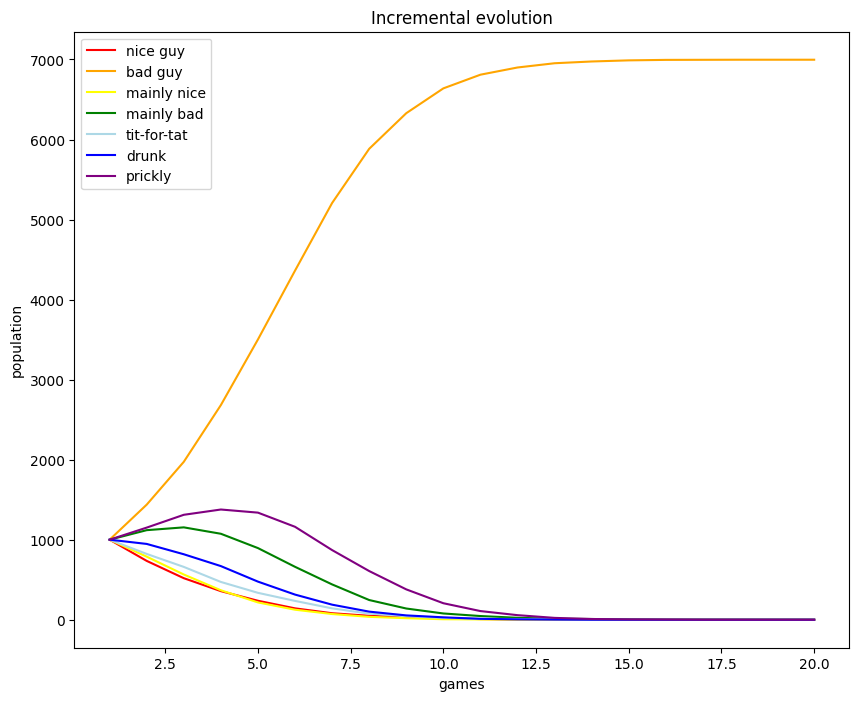

In [ ]:

# implemented strategies
strategies = [nice_guy, bad_guy, mainly_nice, mainly_bad, tit_for_tat, drunk, prickly]
strat_names = ['nice guy', 'bad guy', 'mainly nice', 'mainly bad', 'tit-for-tat', 'drunk', 'prickly']

pop = deathmatch_incremental(strategies, strat_names, plot=True, capacity = 7000, rounds=20)

### Results analysis: incremental deathmatch
Clearly, the winner is the *bad guy* strategy, but as a general rule, the better performing strategies are the ones that defeat with higher probability. In fact:
* *bad guy* has defection probability of 1 (always) and prevailed on the others,
* *prickly* starts to defeat at the first opponent's defeat and never stops, in general defecting even more than the *mainly bad* strategy, placing itself as second,
* *mainly bad* has defection probability of 0.8 and arrived as third,
* *drunk* has defection probability of 0.5,
* *tit for tat* only copies the opponent's behaviour, hence it cannot win but can only manage to tie if the opponent is not evil.
* *mainly nice* and *nice*, the two strategies with the lowest probability of defection, came last.

The population plateaus at 7000 units since each match maintains the total unvaried: the winning strategy will gain 1 follower and the loosing strategy will loose 1 follower, but the total is unchanged. At one point in time, there will be only *bad guys* and they will fight against each other.

This mimics the behaviour that we observed in the first point because the incremental behaviour essentially mimics a series of 1v1 games where the player that wins the match is able to reproduce, while the loosing one dies. This model does not encourage competition, since the nice strategies are able to score more points on average but will likely end on a tie or loosing when they play in a 1v1 scenario.

Nice strategies can earn a high amount of points when playing against other nice strategies, since they both cooperate therefore increasing the points of both players, but this evolution model does not reward strategies that earn a lot of points: it limits itself to granting the victory to the strategy that did better than the opponent.

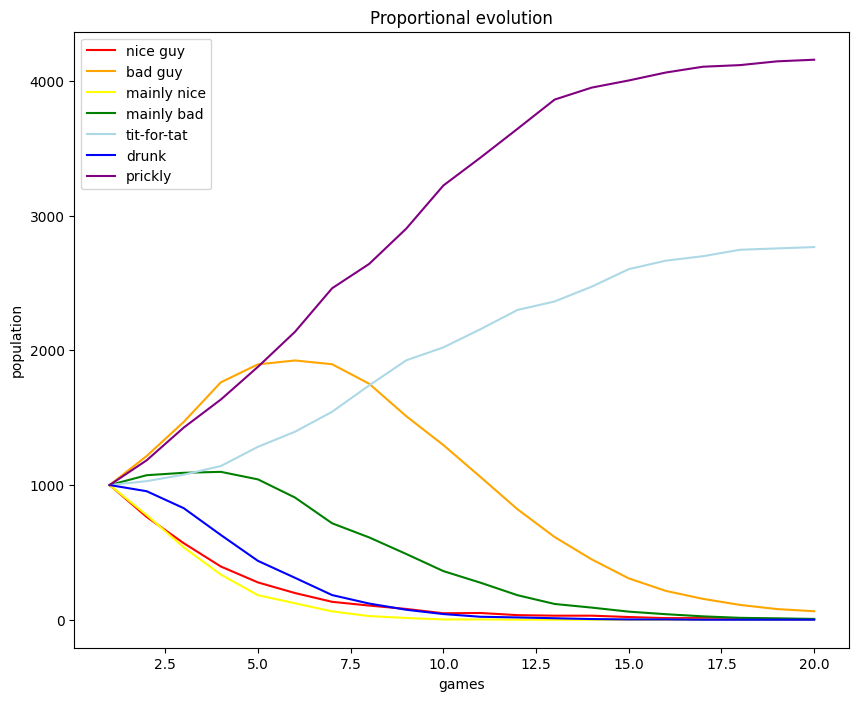

In [ ]:
strategies = [nice_guy, bad_guy, mainly_nice, mainly_bad, tit_for_tat, drunk, prickly]
strat_names = ['nice guy', 'bad guy', 'mainly nice', 'mainly bad', 'tit-for-tat', 'drunk', 'prickly']

pop = deathmatch_proportional(strategies, strat_names, plot=True, capacity = 7000, rounds=20)

### Results analysis: proportional deathmatch

The new evolutional model drastically changed the results: now the better performing strategies are the *prickly* and *tit for tat*. This happens because this model clearly favours the cooperating strategies.

Bad strategies are likely to win every single match against nice strategies and tie against other bad strategies, as we have seen in the previous points. However, this time the victory of a strategy is determined by the total amount of points that it can collectively gather with respect to the total points awarded in total. Bad strategies win the matches but they get fewer points with respect to nice ones, that may loose the match but are on average able to gain many more points, since mutual cooperation brings a greater reward than mutual defection.

The example of the *tit for tat* strategy is clear: against bad strategies, it will only loose by one defection, since *tft* copies the behaviour of the opponent, so their points difference at the end will be small. On the other hand, when playing against themself, *tft* is able to make both player score perfectly since they always cooperate.

*Nice guy* is another example of good strategy, however, while it scores perfectly against other *nice guys*, *tfts* and *prickles*, it can't score a single point when playing against bad guys, and in general is not able to react to the opponent, so if the opponent often defeats, *nice guy* will not try to reduce the score gap and ends up loosing a lot of points.

The gap between the *tft* and *prickly* strategies is explained by the fact that the *prickly* strategy is better than *tft* when playing against *mainly nice* and *nice*. Since those two strategies are not intelligent and their actions do not vary basing on the opponent's behaviour, the *prickly* strategy is able to take advantage of them, gaining an initial advantage. Then, when those strategies will go extinct, *tft* and *prickly* will on average draw, so their proportions will not change substantially and the population will remain stable. We can say that the *tft* strategy initially pays a price for being nicer with other dumb-nice strategies such as the two mentioned above.

## What if there was no *bad guy*: incremental deathmatch
In the previous incremental deathmatch result, we can note that the strategy called *bad guy*  won by a large margin. The question arises: "what if there was no *bad guy* strategy?" In this section we examine a case without it.
It makes sense to examine the behaviour on the incremental model only, since the proportional evolutional model sees the *bad guy* strategy going extinct within the first few rounds.

All the other parameters will remain the same as before.

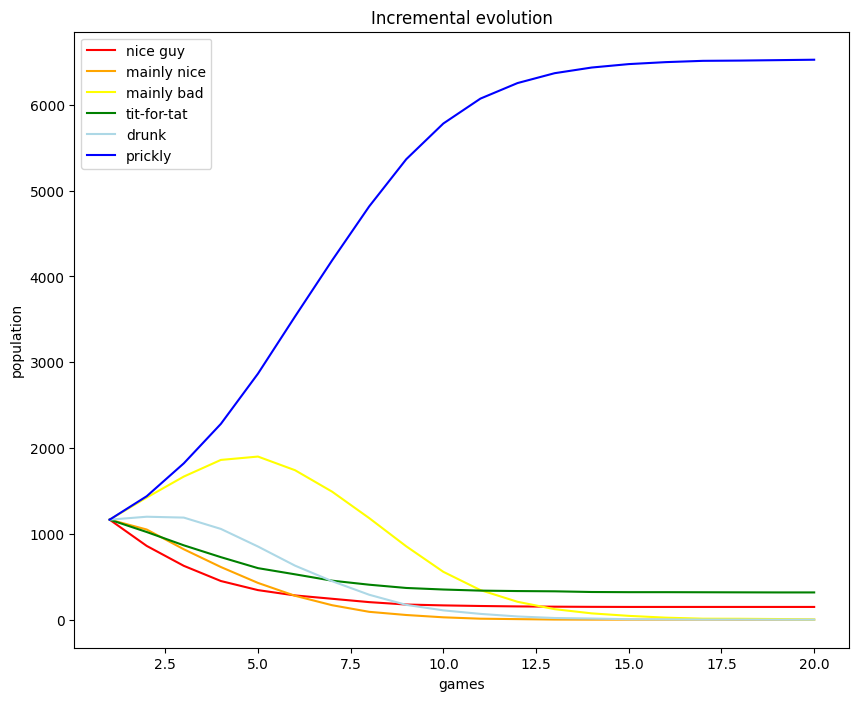

In [ ]:
# implemented strategies
strategies = [nice_guy, mainly_nice, mainly_bad, tit_for_tat, drunk, prickly]
strat_names = ['nice guy', 'mainly nice', 'mainly bad', 'tit-for-tat', 'drunk', 'prickly']

pop = deathmatch_incremental(strategies, strat_names, plot = True, rounds=20)

### Results analysis
As we could reasonably expect, without the presence of the bad guy strategy, *prickly*, the second most successful strategy from the previous plot will win the game and dominate.

The similarities with the previous point, however, end here, because at a closer look there are some substantial differences.

To better appreciate those differences, let us firstly define two different categories of strategies as follows:
* **evil** are the strategies that can defect first even if the opponent never defected before. Such strategies are *mainly bad*, *mainly nice*, *drunk* and *bad guy*, but this last one does not play in this simulation,
* **nice** are the strategies that can't defect first, but can defect only in retaliation after the opponent does so. Such strategies are *tit for tat*, *nice guy* and *prickly*.

We can note that, as per the previous point, the strategy that defects the most wins by a great margin, however in this case the other strategies will not vanish completely. We are in a particular situation where the winning strategy is in fact a **nice** strategy.

Let's break the problem in two by analizing the results when *prickly* plays against a **nice** or an **evil** strategy.

Since there is no *bad guy*, when playing against an **evil** strategy, the *prickly* will win since it will continue to defect after the first opponent defection, and in the long run the *prickly* will defect on average more than even the *mainly bad*, leading to a win.
On the other hand, when playing against a **nice** strategy, the result must be a tie since neither one will defect, and they end up collaborating in every match.

This behaviour leads to an equilibrium: the initial transitorial phase sees the extinction of the **evil** strategies and the rise of the *prickly*. Evil strategies initially win against the **nice** ones except for the *prickly*, against which they surely loose. This process also decreases the population of the *nice guy* and *tit for tat* strategies, which are **nice** strategies, therefore loose against the **evil** ones.

However, once all the **evil** strategies are eliminated by the *prickly* strategy, *prickly*, *nice guy* and *tit for tat* will only play against each other, always resulting in a tie and keeping the populations unvaried in an equilibrium.

#### Real world
Consider now the presence of a sort of human factor, where sometimes with a given probability $p$ each strategy can misinterpret the opponent's behaviour, menaing that a cooperation is interpreted by the opponent as defection and vice versa, a defection can be interpreted as cooperation. This can be the case since the human behaviours in the real world are not always 100% clear and can be interpreted in different ways. In this case, we will once again see the *prickle* strategy win, while the other strategies, even the other nice ones will all go extinct since now, when **nice** strategies play against other **nice** strategies, there is no more guarantee that it will result in a tie.

# Point 4: Mutations

In this last section, we study the effect of genetic mutation on different strategies through population evolution. This problem could be approached in various different ways, although, for simplicity, we have chosen an implementation that represents a tradeoff between faithfulness with respect to real life situations and simplicity of calculations.

The starting strategies are defined as in the previous points and the population is equally divided such that each strategy starts with 1000 players. The total system capacity is thus of 7000 players, and will be kept constant through all the matches. \
Five of the seven chosen strategies have a fixed probability of cooperation, and we call such cooperation probability **gene** , namely

*strategy - gene*
 * nice guy = 1
 * mainly nice = 0.75
 * drunk = 0.5
 * mainly bad = 0.25
 * bad guy = 0


The other two strategies, tit-for-tat and prickly, do not have a fixed probability because their behaviour depends on the opponent's move, therefore they will be treated differently. \
Notice also that we fixed the probability for mainly bad and mainly nice, this was done to avoid confusion in creating a lot of matches between these two strategies.

The game will proceed as explained beforehand: each person will challenge everyone else to a singe match 1vs1 for a total of n rounds. At the end, the population of each strategy is reassigned proportionally to the relative score, and the game will start again. \

In addition to that, at each round the players are allowed to mutate with a fixed probability. A mutation is modeled as a change in a player's gene, i.e.: a change in its cooperation probability, and if the mutation is successfull it will result in a new strategy which will compete 1v1 with all the others. \
The mutation will occur in the following way:\
at each round the gene value of a single person can mutate randomly with probability = mutation_prob, taking a new value in range $[0, 0.25, 0.5, 0.75, 1]$

*   if the player played a strategy with fixed probability, he will be reassigned to the strategy associated to the new gene value \
(*e.g. a nice guy (gene = 1) mutates to a new gene = 0. From now on he will be a bad guy*)
*   if the player played as tit-for-tat or prickly, a completely new strategy will be created and they will be reassigned to it. The new strategy will behave like the original one but in addition there will be a probability of cooperation at each move, given by the gene value\
(*e.g. a prickly mutates with new gene = 0.25. From now on he will be part of the new strategy prickly_25, he will cooperate until the opponent cooperates and then defect forever but with an additional probability to cooperate at each move of 25%*)





### Redefine all the strategies

In [ ]:
# function that starting from the gene value returns the correspondent strategy
def get_strategy_from_gene(gene_value):
    if gene_value == 0:
        return bad_guy
    elif gene_value == 0.25:
        return mainly_bad
    elif gene_value == 0.5:
        return drunk
    elif gene_value == 0.75:
        return mainly_nice
    elif gene_value == 1:
        return nice_guy
    else:
        raise ValueError(f"Invalid gene value: {gene_value}")


# tit-for-tat special case: standard tit-for-tat or collaborates
def tit_for_tat_gene(gene_value: float):
    return tit_for_tat if np.random.uniform() >= gene_value else uc

# prickly special case: standard prickly or collaborates
def prickly_gene(gene_value: float):
    return prickly if np.random.uniform() >= gene_value else uc

# initialize the strategies
strategies = [nice_guy, bad_guy, mainly_nice, mainly_bad, tit_for_tat, drunk, prickly]
strat_names = ['nice guy', 'bad guy', 'mainly nice', 'mainly bad', 'tit_for_tat', 'drunk', 'prickly']
gene = [0,0.25,0.5,0.75,1]
for i in gene:
  strategies.append(tit_for_tat_gene(i))
  strategies.append(prickly_gene(i))
  strat_names.append(f"tit_for_tat_{int(i * 100)}")
  strat_names.append(f"prickly_{int(i * 100)}")

### Utilities functions

In [ ]:
# get mutated version of special case strategies, (tit-for-tat and prickly)
def get_mutated_strategy(original_strategy, gene_value):
    # tit-for-tat case
    if original_strategy == tit_for_tat:
      return tit_for_tat_gene(gene_value = gene_value)

    # prickly case
    elif original_strategy == prickly:
      return prickly_gene(gene_value = gene_value)

    # if not a special case
    else:
        raise ValueError(f"Invalid strategy for mutation: {original_strategy}")

# generates the dictionary in order to handle the strategies
def generate_strategies_map(strategies, strat_names, starting_population : int) -> dict[dict]:
  strategies_map = {}
  for position, strategy in enumerate(strategies):
    strategies_map[strat_names[position]] = {
      'population': starting_population[position],
      'function': strategy
    }
  return strategies_map

# initializes a newly born mutation strategy
def update_strategies(strategies_map, new_strategy_name, new_strategy, df_pop):
  strategies_map[new_strategy_name]['population'] += 1
  return strategies_map, df_pop

# return the populations of all the strategies
def get_populations(strategies_map):
  return [strategy['population'] for strategy in strategies_map.values()]

# return the functions of all the strategies
def get_functions(strategies_map):
  return [strategy['function'] for strategy in strategies_map.values()]

### function `mutation`
Function that implements the deathmatch simulation in the case in which mutations are allowed.

#### Inputs
This function accepts the following inputs:
* *strategies*: list of participant strategies, i.e. list of functions that describe the implemented strategies that we want to see playing against each other.
* *strat_names*: list containing the names of the participant strategies placed in the same order as the *strategies* list, in order to properly save the data in the output dataframe.
* *plot*: boolean that, if true, makes the function show the plot of the evolution of the populations in the various rounds.
* *prob*: float in the range $[0, 0.5)$ representing the probability of the *mainly bad* and *mainly good* strategies.
* *capacity*: integer representing the starting population and maximum allowed population
* *reward*: integer representing the increase in population of the winning players strategies in each game and the decrease of the loosing players strategies.
*  *rounds*: integer representing the number of rounds that the simulation will last.
* *mutation_prob* the propability that each entity mutates at each day
#### Output
* *df_pop*: the dataframe containing the evolution of strategies' populations data over the course of the different rounds.

In [ ]:
def mutation(strategies, strat_names, plot = False, prob=0.25, mutation_prob = 0.05, capacity=7000, reward=1, rounds=20):

  # initialize the starting populations
  starting_population = int(capacity / len(strategies[:7]))
  populations = [0] * len(strategies)
  populations[:7] = [starting_population] * len(strategies[:7])

  # generate the dict to handle all the strategies
  strategies_map = generate_strategies_map(strategies, strat_names, populations)

  iterations = np.arange(1, rounds + 1)
  # dataframe storing the population values initialized all to zero
  df_pop = pd.DataFrame(0, columns=strat_names, index=iterations)
  #added starting population of the first 7 strategies
  df_pop.iloc[0,:] = populations

  # simulation loops
  for round in np.arange(1, rounds+1):
    strategies_name = list(strategies_map.keys())
    # loop through the strategies and do the mutations
    for strategy_name in strategies_name:
      if np.random.uniform() < mutation_prob:
        if strategies_map[strategy_name]['population'] > 0:
          strategies_map[strategy_name]['population'] -= 1
        new_gene = np.random.choice([0, 0.25, 0.5, 0.75, 1])
        if strategy_name in ['tit_for_tat', 'prickly']:
          new_strategy_name = f"{strategy_name}_{int(new_gene * 100)}"
          new_strategy = get_mutated_strategy(strategies_map[strategy_name]['function'], new_gene)
          strategies_map, df_pop = update_strategies(strategies_map, new_strategy_name, new_strategy, df_pop)
        else:
          new_strategy = get_strategy_from_gene(new_gene)
          strategies_map, df_pop = update_strategies(strategies_map, strategy_name, new_strategy, df_pop)

    points_per_strategy = np.zeros(len(strategies))
    matches = random_matches(strategies, populations)
    n = 50 # number of battle for each game
    for match in matches:
      if match[1] != None:
        res1, res2 = one_vs_one(match[0], prob, uc, match[1], prob, uc, n)
        ## update the populations
        ind1 = strategies.index(match[0])
        ind2 = strategies.index(match[1])
        points_per_strategy[ind1] += res1[-1]
        points_per_strategy[ind2] += res2[-1]

    # update the DataFrame

    #populations = ev_proportional(points_per_strategy, capacity) #using the previous evolution criteria
    #for i in range(len(populations)):
    #   strategies_map[list(strategies_map.keys())[i]]['population'] = populations[i]

    df_pop.loc[round, :] = get_populations(strategies_map)

  # if the plot is desired
  if(plot):
    fig, ax = plt.subplots(figsize=(10,8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:pink', 'tab:gray', 'lime', 'indigo', 'salmon', 'gold', 'purple', 'brown']
    line_styles = ['-', '--', '-.']

    for i in range(len(df_pop.columns)):
      color = colors[i % len(colors)]
      line_style = line_styles[i % len(line_styles)]
      ax.plot(df_pop.iloc[:,i].T, label=df_pop.columns[i], color=color, linestyle=line_style)

    ax.set_yscale("log")
    ax.set_title("Mutations")
    ax.set_xlabel('games')
    ax.set_ylabel('population (log)')
    ax.legend()
    plt.show()

  # return the DataFrame
  return df_pop

### Simulation without evolution

In order to compute the the simulation, we have chosen the starting parameters as follows:

* capacity = 700 , in such a way that all the main seven strategies start with 100 entities
* rounds = 300 , the number of matches performed at each game
* mutation_prob = 0.1 , a fairly high value

The values of the above parameters were taken so that we can appreciate the birth and the growth of the new mutated strategies.

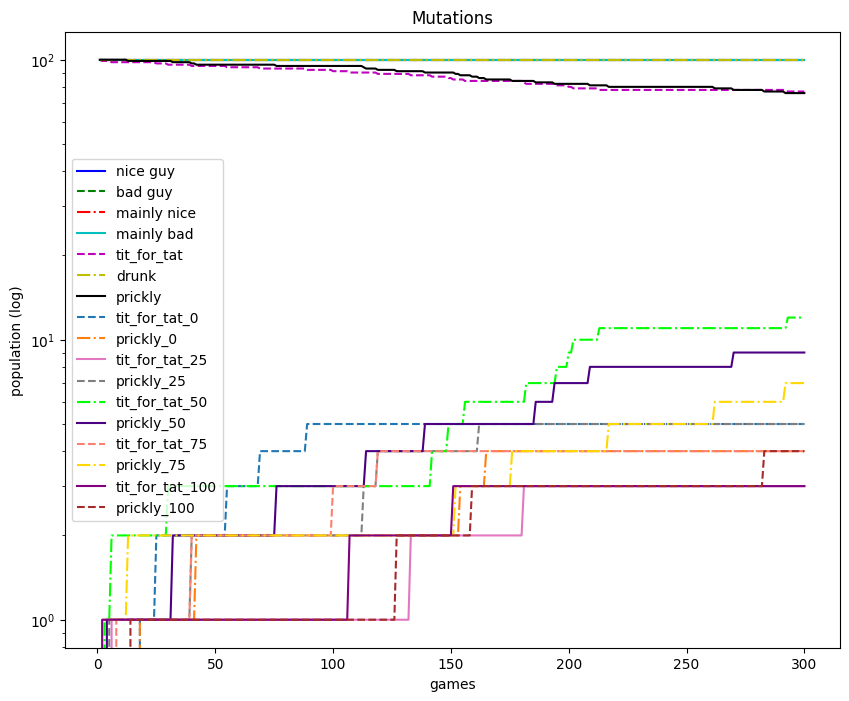

In [ ]:
# initial parameters
capacity = 700
rounds = 300
mutation_prob = 0.1
df_pop = mutation(strategies, strat_names, plot = True, rounds=rounds, capacity=capacity, mutation_prob=mutation_prob)

### Results

As a first comment, one should note that the proportional evolution was disregarded in this configuration and only the mutation contributes to the change in population. This was due to the fact that the newly born strategies would have died before being populated because they would have obtained too few points to reproduce. The corrisponding result would have been the same one of the proportional deathmatch and so it would not have been worth showing in this section. Other evolution functions were considered, but led to the same result.

As we can expect from the way we setup the simulation, the growth of mutated strategies is not appreciable at first sight, in fact we had to increase the number of games. Also, we can immediately note the two descending lines corresponding to the non mutated tit-for-tat and prickly. This happens because the mutations will move players away from the count of the two aforementioned strategies to the count of the mutated ones, while the other strategies do not change because every missing population of those ones would instantly be repopulated by a mutated one.

To see the effects of the proportional evolution together with mutations one should study the much more complex case where the gene is not fixed for the given strategies and so all of them can mutate and fight eachother.


# Alternative implementation of point 4

Here we provide an alternative implementation of the fourth point where we define a single strategy called _random_guy_ and we model the genes as the probability of the random guy to cooperate with its opponent. In the practical implementation, the _random_guy_ function accepts such probability as input parameter. The gene is chosen from the set $[0, 0.25, 0.5, 0.75, 1]$ where 0 means that the player has zero probability of cooperating and will always defect, 0.25 means that the player has 0.25 probability of cooperate and so on.
The starting populations is divided equally into the pool of genes, then at each round each player undergoes a mutation to another random gene with probability $p=0.2$

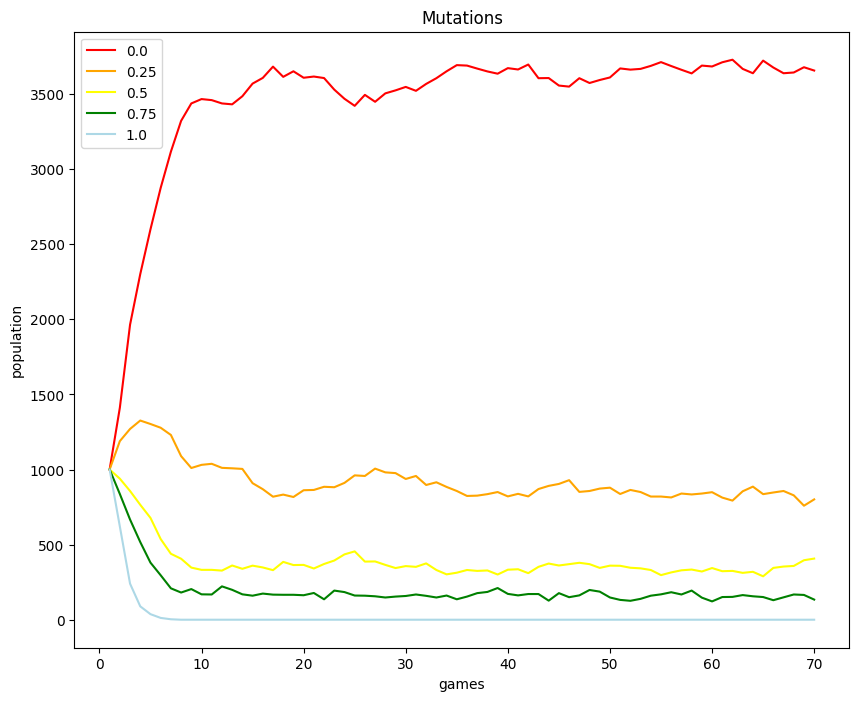

In [ ]:
def random_guy(coop_prob):
  if np.random.random() < coop_prob: return uc
  return ud


def muted_1v1(gene1, gene2, n):
  res1 = [] # points awarded to the gene 1
  res2 = [] # points awarded to the gene 2
  for i in range(n):
    u1 = random_guy(gene1)
    u2 = random_guy(gene2)

    # curr rewards
    r1 = np.dot(u1, np.dot(M, u2))
    r2 = np.dot(u2, np.dot(M, u1))
    res1.append(r1)
    res2.append(r2)

  # cumulative rewards
  res1 = np.cumsum(res1)
  res2 = np.cumsum(res2)

  return (res1, res2)

def mutated_matches(genes, population):
  people = []
  for gene, num in zip(np.arange(0, len(genes)), population):
    people.extend([gene]*num)
  extraction = np.random.permutation(people)
  matches = []
  for i in np.arange(0, int(len(extraction) / 2) + 1, 2):
    index1 = extraction[i] # index of the first gene
    index2 = extraction[i+1] # index of the second extracted gene
    matches.append((genes[index1], genes[index2])) # log the participants of each match
  # odd number of partecipants case
  if(len(extraction % 2 != 0)):
    index = extraction[-1]
    matches.append((genes[index], None))
  return matches # returns the list of 1v1 matches that will be held in the day


def mutations_deathmatch(allowed_mutations = [0, 0.25, 0.5, 0.75, 1], plot = False, capacity=5000, reward=1, rounds=70):
  starting_population = int(capacity / len(allowed_mutations)) # starting population for a mutation
  populations = [starting_population] * len(allowed_mutations) # starting population for all the mutations

  # dataframe in order to save each iteration
  iterations = np.arange(1, rounds + 1)
  df_pop = pd.DataFrame(0, columns=allowed_mutations, index=iterations)
  df_pop.loc[1,:] = populations # populate the first row with the starting populations

  for round in np.arange(1, rounds):
    points_per_strategy = np.zeros(len(allowed_mutations))
    matches =  random_matches(allowed_mutations, populations)
    n = 50 # number of battle for each game
    for match in matches:
      if match[1] != None:
        res1, res2 = muted_1v1(match[0], match[1], n)
        ## update the populations
        ind1 = allowed_mutations.index(match[0])
        ind2 = allowed_mutations.index(match[1])
        points_per_strategy[ind1] += res1[-1]
        points_per_strategy[ind2] += res2[-1]

    # update populations
    populations = ev_proportional(points_per_strategy, capacity)
    df_pop.iloc[round, :] = populations

    # list all the genes except the one that performed the best
    less_performing = points_per_strategy < max(points_per_strategy)
    less_performing = np.array(allowed_mutations)[less_performing]
    for gene in allowed_mutations:
      for player in range(populations[allowed_mutations.index(gene)]):
        if(np.random.random()< 0.2):
          gene_dest_index = np.random.randint(0,len(allowed_mutations)-1)
          populations[allowed_mutations.index(gene)] -= 1
          populations[gene_dest_index] += 1

  if(plot): deathmatch_plot(df_pop, "Mutations")
  return df_pop

df = mutations_deathmatch(plot=True)

### Results analysis
After the now familiar initial transient period lasting for less than 10 rounds, we note the populations reach an equilibrium given by the fact that at each round we still have the population recalculation as we did in point 3 with the proportional evolutionary model, so we expect to have similar results. However, since we do not have a prickle strategy that can keep up with the bad guy (the gene with coop probability set to zero) and neither do we have the tit for tat, but only random strategies, the win of the bad guy is a safe bet and an expected result.

The mutations only add some local random perturbations to the balance reached by the players, but since at the end of the round each strategy must compete with the others in terms of points gained, in the big scheme of things those mutations are not able to substantially vary the result, only adding a sort of noise to the equilibrium.

This can be expected, from the prevalence of a bad strategy in a world of randomness and no retaliation, to the equilibrium reached at the end since each strategy will have its asymptotic behaviour (ex.: in infinite rounds, the cooperation of each player implementing a certain gene will tend to the value of the gene itself. While the outcome of a single game is random, in the long term we can determine the expected value of the score of the two strategies, leading to an equilibrium past a certain number of rounds.)